In [6]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

n_range = range(164, 171)
N = len(n_range)
    
SXM_PATH = ["electromigration_28/Image_{0:03}.sxm".format(i) for i in n_range] #Replace value as appropriate
base_filename = "electromigration_28_{0:03}-{1:03}_tiled".format(n_range[0],n_range[-1])
#SXM_PATH = "electromigration_8/Image_001.sxm"
OUTPUT = "./jpg/"

import matplotlib as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import pySPM as spm 
import trackpy as tp
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        #self.filenames = glob.glob(filename_pattern)
        self.filenames = filename_pattern
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").pixels for s in self.scans]) #grab z-channel
        self.z_data = np.array([s.get_channel("Z").correct_lines().pixels for s in self.scans]) #grab z-channel
        #self.z_data = np.array([s.get_channel("Bias").pixels for s in self.scans]) #grab z-channel
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype
    
frames = SXMReader(SXM_PATH)
frames=frames[::1]
mpl.rc('image', origin='lower')
#new_frames=[]
#for i,frame in enumerate(frames):
#    new_frames.append(frame[::-1])
#frames=new_frames

In [3]:
len(n_range)

7

(-0.5, 95.5, -0.5, 95.5)

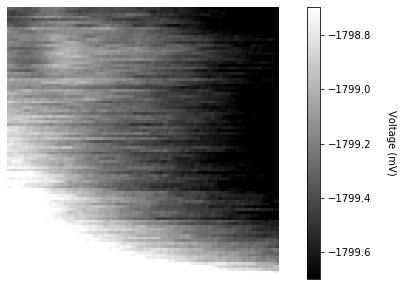

In [288]:
fig = plt.figure()
frame = frames[6]*1000
plt.imshow(-frame)
avg = np.average(-frame)
plt.clim(avg-0.5,avg+0.5)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Voltage (mV)', rotation=270, labelpad =25)
plt.axis('off')

In [293]:
z=np.array(frame).ravel()
x, y = np.meshgrid(np.linspace(-50,50,96),np.linspace(-50,50,96))
#z = 2*x + y + 100
Z=np.array(frame).ravel()
X = np.transpose(np.vstack([x.ravel(), y.ravel()]))
#Z = np.transpose(z.ravel())
theta = np.linalg.inv(np.dot(np.transpose(X),X)).dot(np.transpose(X)).dot(Z)
print(theta)
print(np.linalg.norm(theta))

[0.00987574 0.00850552]
0.013033577443845885


[0.00987574 0.00850552]
1.3033577443845885


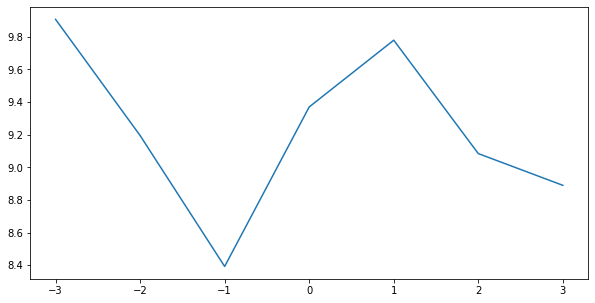

In [120]:
gradient = []
for i in range(len(frames)):
    gradient.append(np.max(frame[i]) - np.min(frame[i]))
gradient = np.array(gradient) *1000 / 141 
plt.plot(np.linspace(-3,3,7),gradient)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

m = 256 #size of the matrix

X1, X2 = np.mgrid[:m, :m]

fig = plt.figure()
ax = fig.add_subplot(3,1,1, projection='3d')
jet = plt.get_cmap('jet')

#generation of the surface
F = 3        
i = np.minimum(X1, m-X1-1)
j = np.minimum(X2, m-X2-1)
H = np.exp(-.5*(np.power(i, 2)  +  np.power(j, 2)   )/(F*F))
Y = np.real(  np.fft.ifft2   (H  *  np.fft.fft2(  np.random.randn(m, m))))
a = 0.0005; b = 0.0002; #parameters of the tilted plane
Y = Y + (a*X1 + b*X2); #adding the plane
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) #data scaling

#plot the initial topological surface
ax.plot_surface(X1,X2,Y, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)


#Regression
X = np.hstack(   ( np.reshape(X1, (m*m, 1)) , np.reshape(X2, (m*m, 1)) ) )
X = np.hstack(   ( np.ones((m*m, 1)) , X ))
YY = np.reshape(Y, (m*m, 1))

theta = np.dot(np.dot( np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)

plane = np.reshape(np.dot(X, theta), (m, m));

ax = fig.add_subplot(3,1,2, projection='3d')
ax.plot_surface(X1,X2,plane)
ax.plot_surface(X1,X2,Y, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)


#Subtraction
Y_sub = Y - plane
ax = fig.add_subplot(3,1,3, projection='3d')
ax.plot_surface(X1,X2,Y_sub, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31375/2011073657.py", line 46, in <module>
    plt.show()
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/matplotlib/pyplot.py", line 378, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/matplotlib_inline/backend_inline.py", line 43, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  Fi

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31375/2011073657.py", line 46, in <module>
    plt.show()
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/matplotlib/pyplot.py", line 378, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/matplotlib_inline/backend_inline.py", line 43, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  Fi

In [2]:
for i, f in enumerate(frames):
    plt.imsave(OUTPUT + SXM_PATH[i][:-4] + '.jpg', frames[i][::-1])

In [227]:
OUTPUT + SXM_PATH[0][:-4] + '.jpg'

'./jpg/electromigration_15/Image_581.jpg'

In [222]:
frames

Sliced SXMReader. Original repr:
    <Frames>
    Length: 10 frames
    Frame Shape: 192 x 192
    Pixel Datatype: float64

In [2]:
## Output image to ./output/electromigration_n/Image_{}.png
#for i, f in enumerate(frames.filenames):
#    plt.imsave(OUTPUT + basename(f)[:-4] + '.png', frames.get_frame(i))

In [157]:
for i in range(1):
    print(i)

0


In [170]:
ax[1]

ERROR! Session/line number was not unique in database. History logging moved to new session 1687


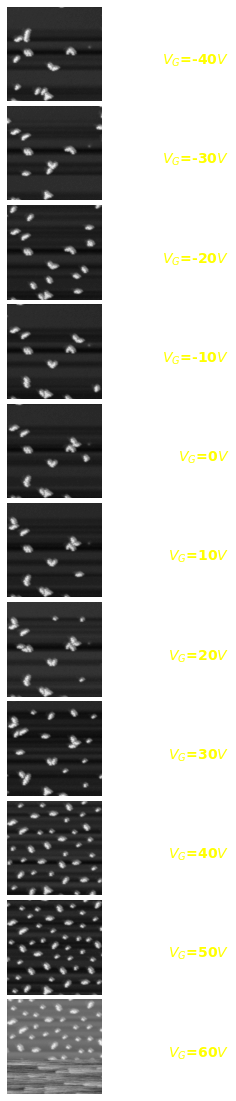

In [3]:
## Output matrix of images to ./output/electromigration_8_{0:03}-{1:03}_tiled.png
x, y = 11, 1
#V = [-5,5,-4,4,-3,3,-2,2,-1,1]
#V = np.arange(0,10*N,10)
V = np.arange(-40,70,10)
#V=[0,3,3,3,10,10,10,10,20,20,20,20,20,20,40,40,40,40,40,40,40]
#V=[i for i in range(60, -65, -5)]
#T=["0s", "100us", "1ms", "10ms", "100ms", "1s", "10s", "100s"]
# V=np.cumsum(V)
#for i, f in enumerate(frames.filenames):
mpl.rc('figure',  figsize=(40, 20))
fig, ax = plt.subplots(x, y)
plt.subplots_adjust(wspace=-0.84, hspace=0.05) #for 25 images (wspace=-0.8, hspace=0.05) #wspace=-0.69, hspace=0.01 #wspace=-0.1, hspace=0.01
#for i in range(x):
for j in range(x):
    #k = (i * y + j) % (x + y)
    #k = i * y + j
    #print(i)
    #print(j)
    #if k < N:
        #ax[i,j].imshow(frames[k])
    ax[j].imshow(frames[j])
    ax[j].text(600,100, "$V_G$={}$V$".format(V[j]), ha="right", weight='bold', color="yellow", fontsize =14)
        #ax[i,j].text(10,220, "V$_G$={}V".format(V[k]), ha="left", weight='bold', color="yellow", fontsize =14)
    #ax[i,j].invert_yaxis()
    ax[j].axis('off')
    ax[j].set_aspect('equal')
        
plt.savefig(os.path.join(OUTPUT,base_filename), bbox_inches='tight')

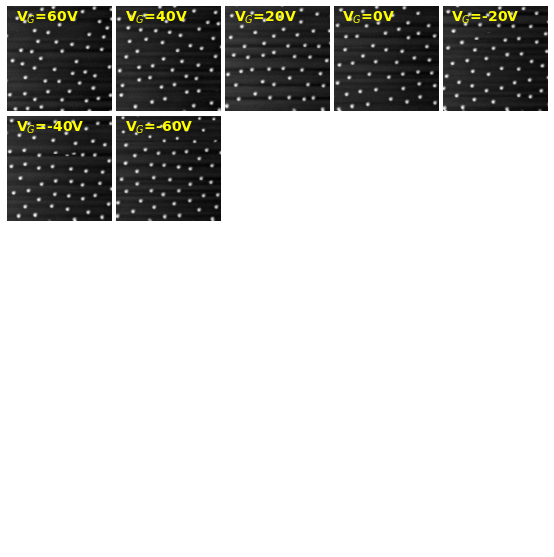

In [7]:
## Output matrix of images to ./output/electromigration_8_{0:03}-{1:03}_tiled.png
x, y = 5, 5
#V = [-5,5,-4,4,-3,3,-2,2,-1,1]
#V = np.arange(0,10*N,10)
V = np.arange(60,-70,-20)
#V=[0,3,3,3,10,10,10,10,20,20,20,20,20,20,40,40,40,40,40,40,40]
#V=[i for i in range(60, -65, -5)]
#T=["0s", "100us", "1ms", "10ms", "100ms", "1s", "10s", "100s"]
# V=np.cumsum(V)
#for i, f in enumerate(frames.filenames):
mpl.rc('figure',  figsize=(20, 10))
fig, ax = plt.subplots(x, y)
plt.subplots_adjust(wspace=-0.84, hspace=0.05) #for 25 images (wspace=-0.8, hspace=0.05) #wspace=-0.69, hspace=0.01 #wspace=-0.1, hspace=0.01
for i in range(x):
    for j in range(y):
        #k = (i * y + j) % (x + y)
        k = i * y + j
        #print(i)
        #print(j)
        if k < N:
            ax[i,j].imshow(frames[k])
            #ax[k].imshow(frames[k])
            #ax[k].text(180,160, "{}$V_S$".format(V[k]), ha="right", weight='bold', color="yellow", fontsize =14)
            ax[i,j].text(10,110, "V$_G$={}V".format(V[k]), ha="left", weight='bold', color="yellow", fontsize =14)
        #ax[i,j].invert_yaxis()
        ax[i,j].axis('off')
        ax[i,j].set_aspect('equal')
        
plt.savefig(os.path.join(OUTPUT,base_filename), bbox_inches='tight')

In [117]:
V = [-5,5,-4,4,-3,3,-2,2,-1,1]

In [118]:
V[0]

-5

In [ ]:
#im.save('out.gif', save_all=True, append_images=frames)